## Tensorflow_for_LendingClubData

First we are analyzing the data to get an understanding about the relations and content.
In the second chapter we are training a NN with Keras and Tensorflow on this dataset.

This exercise was done during an udemy course.

In [353]:
# Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from summarytools import dfSummary
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint

%matplotlib inline

In [168]:
# Get data information
data_info = pd.read_csv('lending_club_info.csv',index_col='LoanStatNew')

print(data_info)

                                                            Description
LoanStatNew                                                            
loan_amnt             The listed amount of the loan applied for by t...
term                  The number of payments on the loan. Values are...
int_rate                                      Interest Rate on the loan
installment           The monthly payment owed by the borrower if th...
grade                                            LC assigned loan grade
sub_grade                                     LC assigned loan subgrade
emp_title             The job title supplied by the Borrower when ap...
emp_length            Employment length in years. Possible values ar...
home_ownership        The home ownership status provided by the borr...
annual_inc            The self-reported annual income provided by th...
verification_status   Indicates if income was verified by LC, not ve...
issue_d                             The month which the loan was

## 1. Data Import and Exploratory Analytics

In [170]:
# Load dataset
df = pd.read_csv('lending_club_loan_two.csv')
dfSummary(df)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,loan_amnt[float64],Mean (sd) : 14113.9 (8357.4)min < med < max:500.0 < 12000.0 < 40000.0IQR (CV) : 12000.0 (1.7),"1,397 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAACsElEQVR4nO3dTW7aQBiA4W/KjwxIthAS7LhApS5YcogetkfoghNwg+yQEDLCiYsx7qJNpCqBwPyU+az32Tvx4hXyfIwH0zSNALH78ugbAG7RffQNXGOMGYhI3/LyY9M0Lz7vB48TbajGmMFkMvmepunY5vr9fr8zxvwg1naINlQR6adpOl4uly9ZlpX3XJjnebJarcbb7bYvIoTaAjGHKiIiWZaV0+n02eLSgfebwcOwmIIKhAoVCBUqECpUCLqYcpyDpufzuefzfqBXsFBd56BVVSV1XX8ty/KniNis+tEiIT9RreegIiJPT0/j9Xo9PJ1OnRA3B12Cz1Ft56C73Y45KN6wmIIKhAoVCBUqECpUIFSoQKhQgVChAqFCBUKFCoQKFQgVKkT/zpStuq57IpIaY2z/BK9bR6SVoRZF0auq6tt8Pu90Op27d26J8Lp1bFoZ6vF47CZJMlwsFuVsNtvdez2vW8enlaG+Go1Gtq9ai/C6dVRYTEEFQoUKhAoVCBUqtHox5cJxDssM1jNC/YDrHJYZrH+E+gGXOSwz2DAI9QqHOSwzWM9YTEEFQoUKhAoVCBUqECpUIFSoQKhQgVChwqcDf4fjzTnaHN5cDdXleHOONodPn32iWh9vztHm8Omm7/ptjjfnaHP4xKaUANjL6h+hesZe1jAI1TP2soZBqIHY7mWt6zoVjiJ6h1AjwlFElxFqRDiK6DJCjRBHEb1HqHjj+GvgIgGfjwkVIuL+a+AiYZ+PCRWvnH4NPPTzMaHiH7a/Bv5XsOdjQm0Zh69vo96WSagt4jKHjX1bJqG2iMscNvZtmYTaQjZz2Ni3ZfLOFFQgVKhAqFCBUKECoUKFm1b9eZ4n9/7hw+GQiIgURZFsNpvh/7xe6//Wet8ifxqp67or9pu+fzVNc3H2+xsDlp0aWh+8DgAAAABJRU5ErkJggg=="">",0(0.0%)
2,term[object],1. 36 months2. 60 months,"302,005 (76.3%)94,025 (23.7%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAABPUlEQVR4nO3bQWrDMBRF0a9iQjORMAYvxovoYrsI7cYYa5CETNRBJ6HDWjx9nHtW8CE3gRi/UGs1QCGY2dXMLr0PQXPPWuu99xGvhmmavmKMY+9D0FYpZQshfHsKbogxjsuy3FNKj97HoI193z9zzuO6rhcz8xObmVlK6THP8633MWjq2vuAvz56H4D3QWyQITbIEBtkiA0yxAYZYoMMsUGG2CBDbJAhNsgQG2SIDTLEBhlig8xg9vuyXe9D0I7Xz3MopWw559EcvmyH/yulbGb27H3HKwYv5+Vu8BKY8kHF6y+bu28ljnM55fM4Q8Nx7qZ8XmdoOM7rlI9/xifEQ13IEBtkiA0yxAYZYoMMsUGG2CBDbJAhNsgQG2SIDTLEBhligwyxQYbYIONuyufpFrTlcsrncYaG4xi8QOYHCltq3yMaNyQAAAAASUVORK5CYII="">",0(0.0%)
3,int_rate[float64],Mean (sd) : 13.6 (4.5)min < med < max:5.3 < 13.3 < 31.0IQR (CV) : 6.0 (3.0),566 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAACmklEQVR4nO3cQW7aQBSA4TclIAOqLYQEOy4QqQuWHKKH7ba7LjgBN2CDkJAxwo2DMe4q2TWBGbueN/2//ZCR8sth5DcxdV0L4LsvXW8AuMdT1xv4iDFmKCIDy+WXuq5fmtwPuuNtqMaY4XQ6/R7H8cRm/el0So0xP4g1DN6GKiKDOI4nq9XqJUmS4pGFWZZF6/V6cjgcBiJCqAHwOVQREUmSpJjNZr8tlg4b3ww6w2EKKnj/RLVVVVVfRGJjjO1HcBjzSJCh5nneL8vy22Kx6PV6vYe+377hMOaXIEO9XC5PURSNlstlMZ/P00fXcxjzT5ChvhmPx7YHMREOY17hMAUVCBUqECpUIFSoQKhQgVChAqFCBUKFCoQKFQgVKhAqVAj6Xb8LxzFBRgQb1mqojpfz4tvt1m9yP/dyHRNkRLB5rYXqejmvLMuoqqrnoih+iYjtBJQVlzFBRgTb0eYT1fpynojIdrudbDab0fV67bWxuXs4jAkyItiw1r+j2l7OS9OUXzbeceqHCoQKFQgVKhAqVCBUqECoUIFQoQKhQgVChQqEChUIFSoQKlQgVKjw6fSUw/BzZ4PPXeN2QPM+DNVl+LnLwecucTugHZ89Ua2Hn30YfO4CtwPacdfgtM3w8/8++MztgGZxmIIKhAoVCBUqECpUIFSoQKhQgVChAqFCBUKFCoQKFQgVKhAqVCBUqMC/RveM49C1SKCD14TqEdeha5FwB68J1SMuQ9ciYQ9eE6qHHIauRQIdvOYwBRV4ogYm1BuwhBqQkG/AEmpAQr4BS6gBCvEGLIcpqECoUIE//Xjn8+vbu0LNsix69IPP53MkIpLnebTf70f/cr3Wn93lvne73VfX17fH4/FsjPkpIjbrX+u6/uu6P8yihCjUJjZpAAAAAElFTkSuQmCC"">",0(0.0%)
4,installment[float64],Mean (sd) : 431.8 (250.7)min < med < max:16.1 < 375.4 < 1533.8IQR (CV) : 317.0 (1.7),"55,706 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAACnUlEQVR4nO3dvY7aQBRA4TthIQYiG0QCHS1FpBSUPEQeNo8QJFoa3oAOySAjHLwYcKqtwv4wY+/Odc7X27g462U8jMcURSGA7z599AUAb/FQ5cmNMW0RaTmc4lQUxbGs64FelYVqjGkPBoOfYRj2bc+x3+93xphfxIoq76itMAz7s9nsGEVRdu/BSZIEi8WiH8dxS0QI9T9X6b9+EZEoirLhcPjH8vB2qRcDtRhMQYXK76guLpdLU0RCY4zN4QzEasTbUNM0beZ5/mM8Hjcajcbd33EZiNWLt6GeTqeHIAg60+k

<Axes: xlabel='loan_status', ylabel='count'>

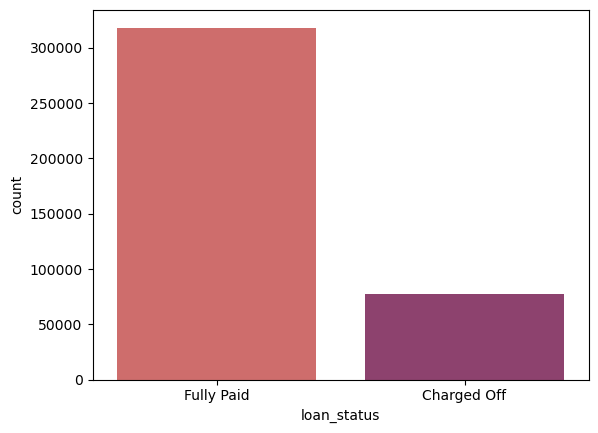

In [171]:
# Loan status

sns.countplot(data = df, x="loan_status", hue="loan_status", palette="flare")

<Axes: xlabel='loan_amnt', ylabel='Count'>

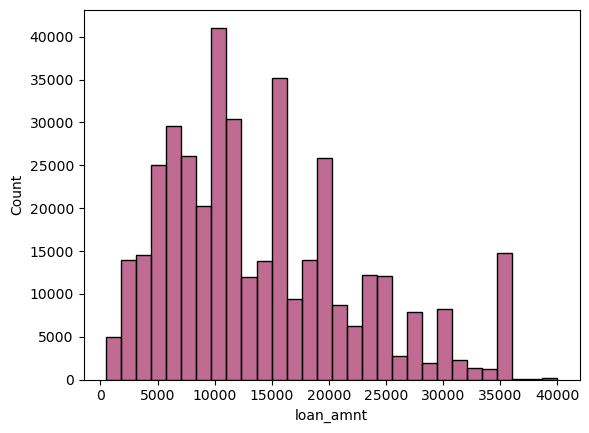

In [172]:
# Loan Distribution


sns.histplot(data=df, x="loan_amnt", bins=30, color="#AB3A6D")

<Axes: >

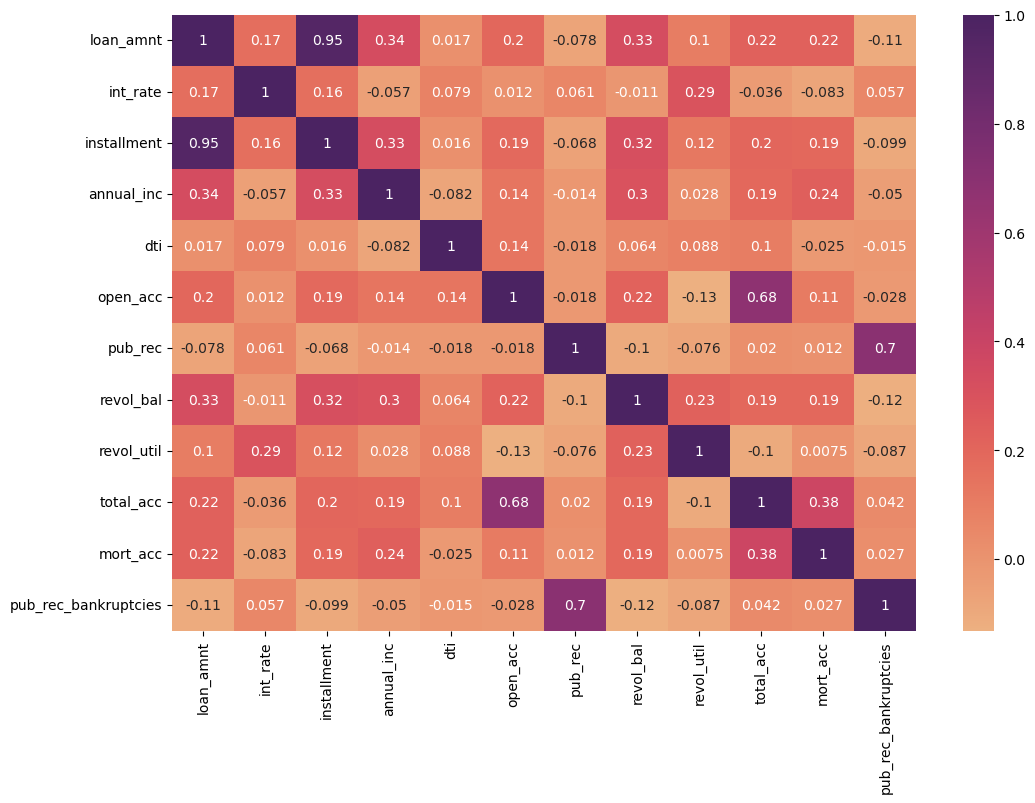

In [173]:
# Correlations

corr = df.corr(numeric_only=True)

plt.figure(figsize=(12,8))

sns.heatmap(data=corr, annot=True, cmap="flare")

The monthly payment owed by the borrower if the loan originates.


<Axes: xlabel='installment', ylabel='loan_amnt'>

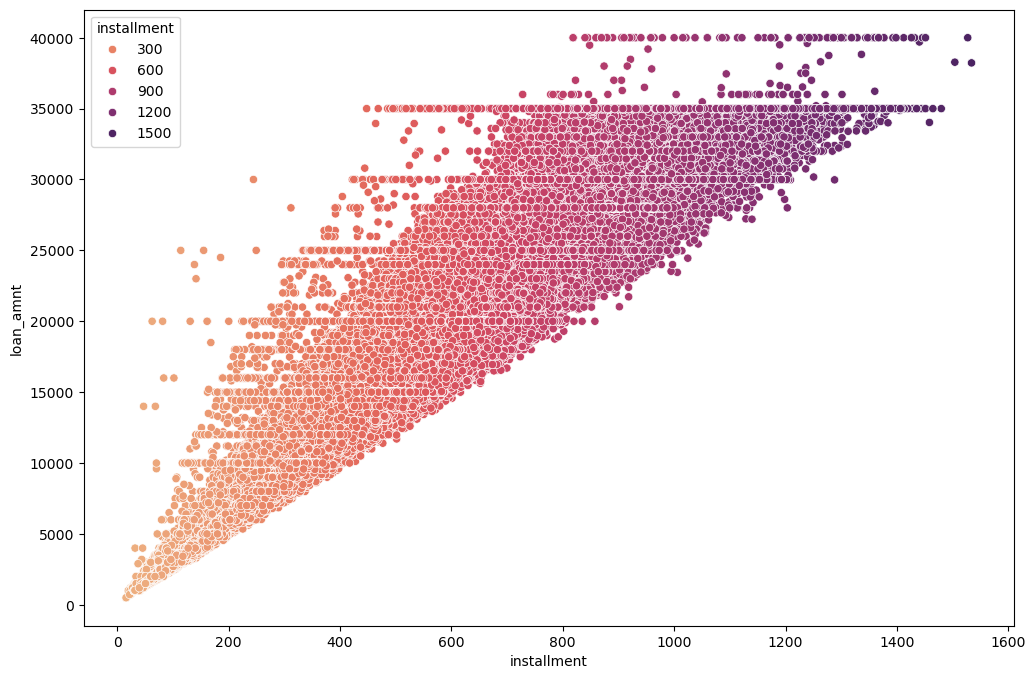

In [174]:
# Correlation between Installment and Loan_amnt

print(data_info.loc["installment"]["Description"])

plt.figure(figsize=(12,8))
sns.scatterplot(data=df, x="installment", y="loan_amnt", hue="installment", palette="flare")

<Axes: xlabel='loan_status', ylabel='loan_amnt'>

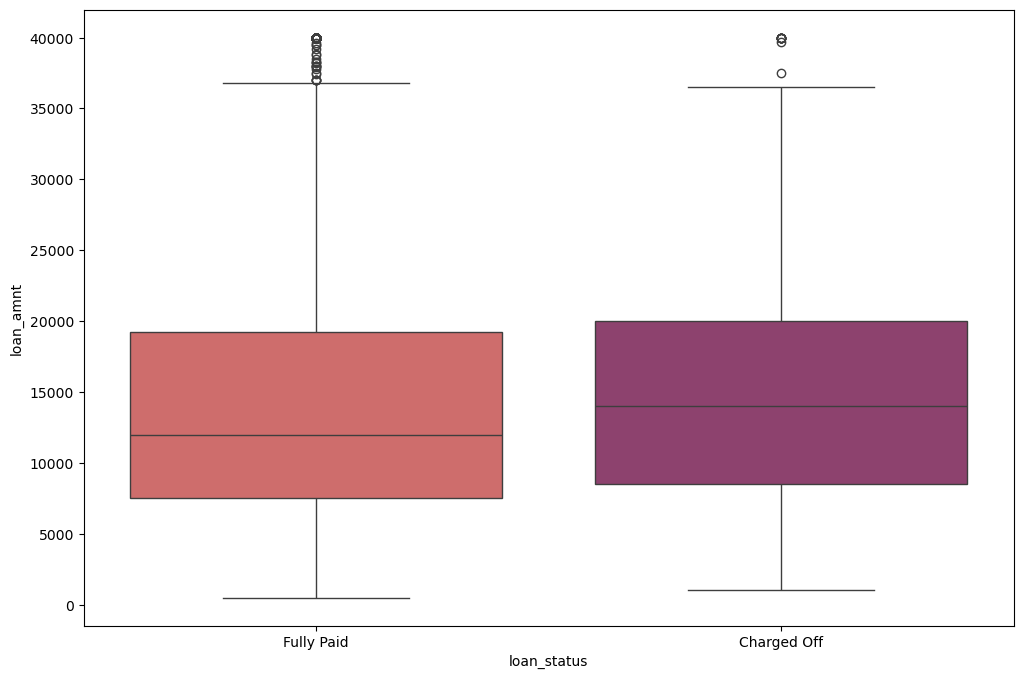

In [175]:
# Distribution Amount
plt.figure(figsize=(12,8))
sns.boxplot(data=df, x='loan_status', y='loan_amnt', hue="loan_status", palette="flare") 

In [176]:
# Statistics per Loan_status

df.groupby('loan_status')['loan_amnt'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,77673.0,15126.300967,8505.090557,1000.0,8525.0,14000.0,20000.0,40000.0
Fully Paid,318357.0,13866.878771,8302.319699,500.0,7500.0,12000.0,19225.0,40000.0


In [177]:
# Loan grades

print(f"Loan grades: {sorted(df["grade"].unique())}")
print(f"Loan subgrades: {sorted(df["sub_grade"].unique())}")

Loan grades: ['A', 'B', 'C', 'D', 'E', 'F', 'G']
Loan subgrades: ['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5']


<Axes: xlabel='grade', ylabel='count'>

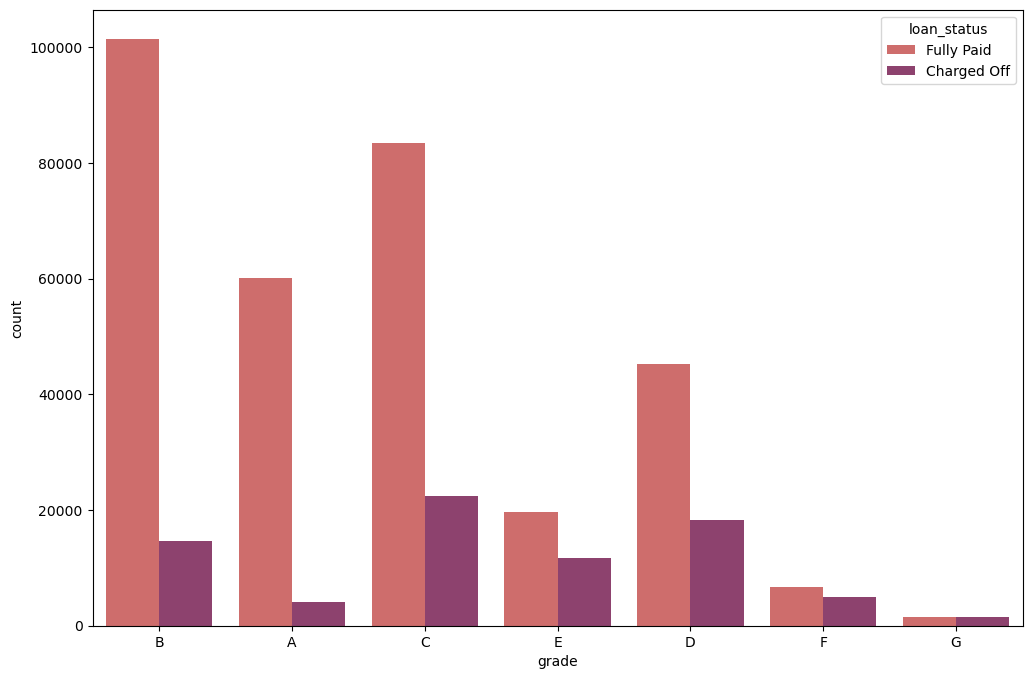

In [178]:
# Loan status by Grade

plt.figure(figsize=(12,8))
sns.countplot(x="grade", data=df, hue="loan_status", palette="flare")

<Axes: xlabel='sub_grade', ylabel='count'>

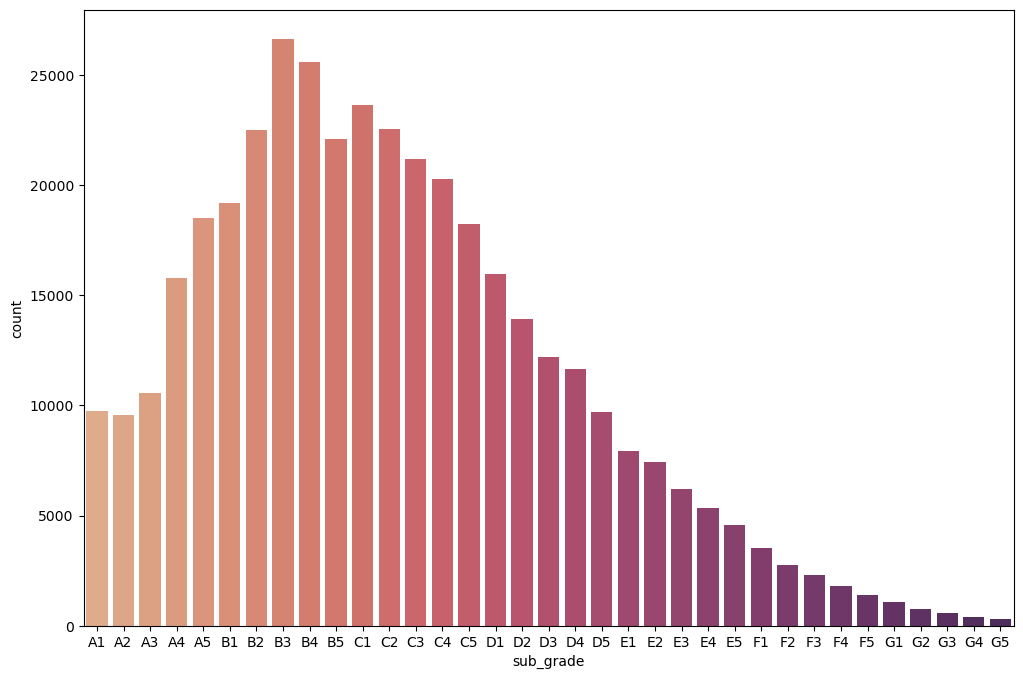

In [179]:
# Sub_grade Distribution

plt.figure(figsize=(12,8))

df_sorted_subgrade = df.sort_values(by="sub_grade", axis=0)

sns.countplot(x="sub_grade", data=df_sorted_subgrade,  legend=False, hue="sub_grade", palette="flare")

<Axes: xlabel='sub_grade', ylabel='count'>

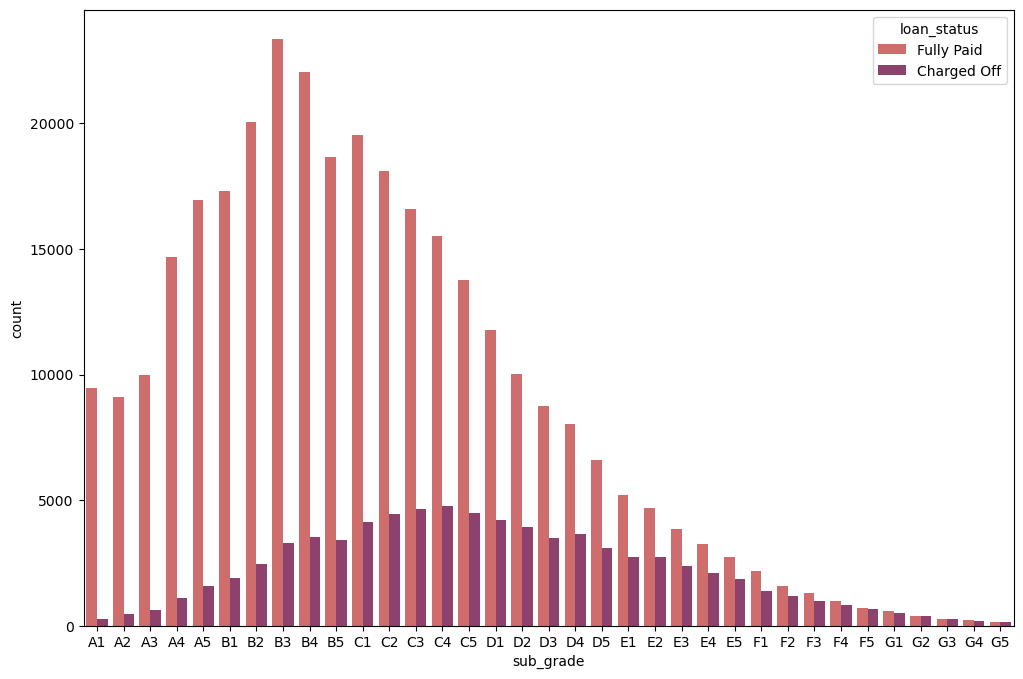

In [180]:
# Loan Status by Subgrade Distribution

plt.figure(figsize=(12,8))
sns.countplot(x="sub_grade", data=df_sorted_subgrade, hue="loan_status", palette="flare")

In [181]:
# Categorie Loan_status to Dummy_value

df["loan_repaid"] = np.where(df["loan_status"] == "Fully Paid", 1, 0)
df.filter(items=["loan_repaid", "loan_status"])

,loan_repaid,loan_status
0,1,Fully Paid
1,1,Fully Paid
2,1,Fully Paid
3,1,Fully Paid
4,0,Charged Off
...,...,...
396025,1,Fully Paid
396026,1,Fully Paid
396027,1,Fully Paid
396028,1,Fully Paid


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, 'int_rate'),
  Text(1, 0, 'revol_util'),
  Text(2, 0, 'dti'),
  Text(3, 0, 'loan_amnt'),
  Text(4, 0, 'installment'),
  Text(5, 0, 'open_acc'),
  Text(6, 0, 'pub_rec'),
  Text(7, 0, 'pub_rec_bankruptcies'),
  Text(8, 0, 'revol_bal'),
  Text(9, 0, 'total_acc'),
  Text(10, 0, 'annual_inc'),
  Text(11, 0, 'mort_acc')])

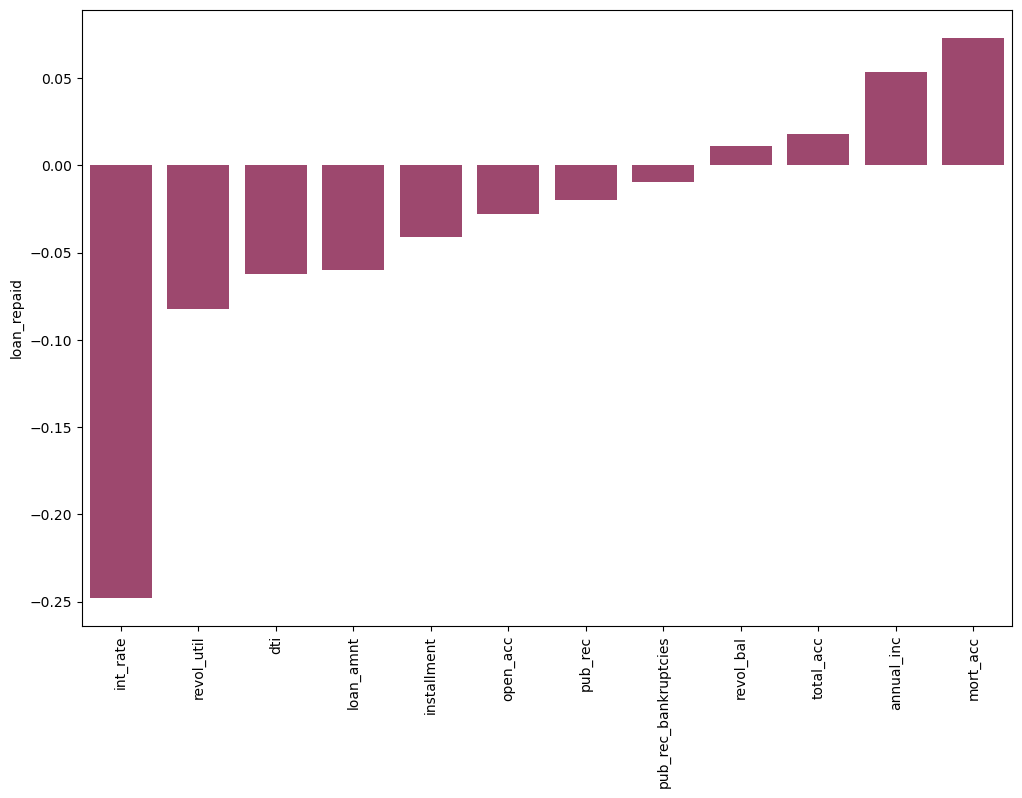

In [182]:
#  Correlation Loan_repaid - Features

plt.figure(figsize=(12,8))
sns.barplot(data=df.corr(numeric_only=True)["loan_repaid"].drop("loan_repaid").sort_values(), color="#AB3A6D")
plt.xticks(rotation=90)

## 2. Data Preprocessing

In [184]:
# Missing values percentage

df.isnull().sum()/len(df)*100

loan_amnt               0.000000
term                    0.000000
int_rate                0.000000
installment             0.000000
grade                   0.000000
sub_grade               0.000000
emp_title               5.789208
emp_length              4.621115
home_ownership          0.000000
annual_inc              0.000000
verification_status     0.000000
issue_d                 0.000000
loan_status             0.000000
purpose                 0.000000
title                   0.443401
dti                     0.000000
earliest_cr_line        0.000000
open_acc                0.000000
pub_rec                 0.000000
revol_bal               0.000000
revol_util              0.069692
total_acc               0.000000
initial_list_status     0.000000
application_type        0.000000
mort_acc                9.543469
pub_rec_bankruptcies    0.135091
address                 0.000000
loan_repaid             0.000000
dtype: float64

In [185]:
# Drop empty rows
# Improvement task: use ML and AI to fill mepty values

df = df.drop('emp_title', axis=1)

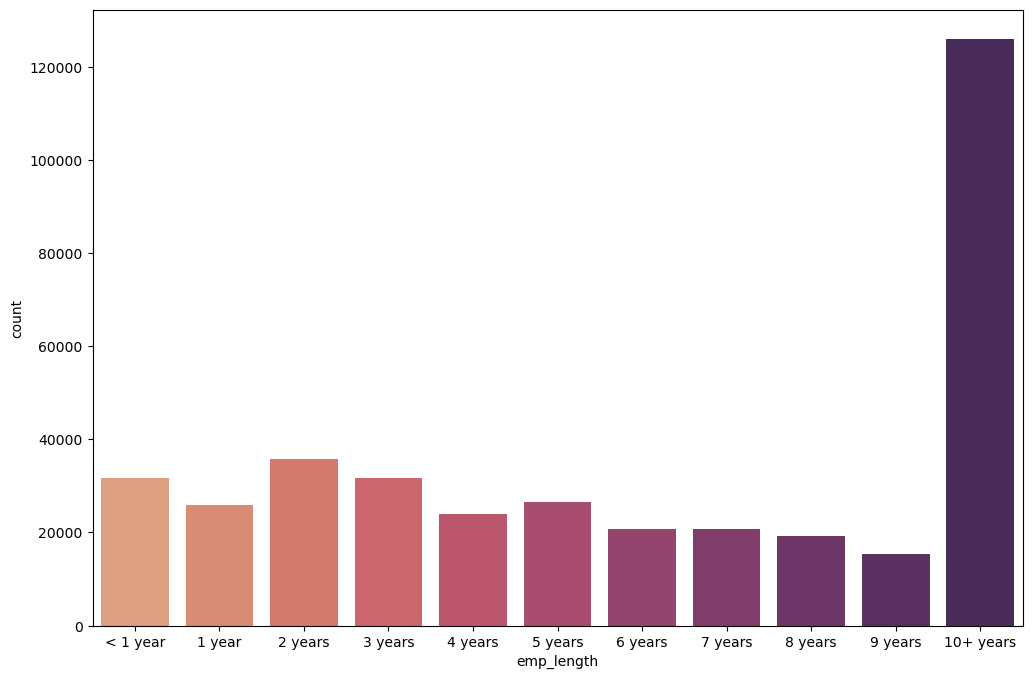

In [186]:
# Employment length
def extract_years(exp):
    if isinstance(exp, float):  # Handle NaN or non-string values
        return -1
    if "< 1" in exp:
        return 0
    return int(''.join([c for c in exp if c.isdigit()]))


df_ordered_emp_length = df
df_ordered_emp_length["emp_years"] = df_ordered_emp_length["emp_length"].apply(extract_years)
df_ordered_emp_length = df_ordered_emp_length.sort_values(by=["emp_years"])

plt.figure(figsize=(12,8))
g = sns.countplot(data=df_ordered_emp_length, x="emp_length" , hue="emp_years", palette="flare")
g.legend_.remove()

<Axes: xlabel='emp_length', ylabel='count'>

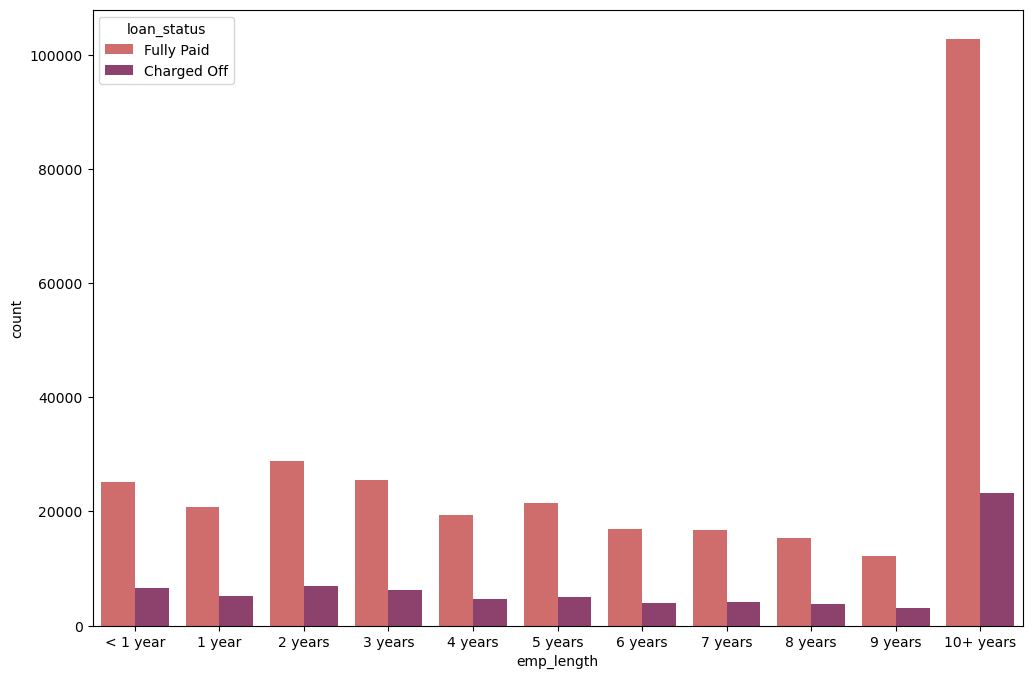

In [187]:
# Loan_status by employment_length

plt.figure(figsize=(12,8))
sns.countplot(data=df_ordered_emp_length, x="emp_length", hue="loan_status", palette="flare")

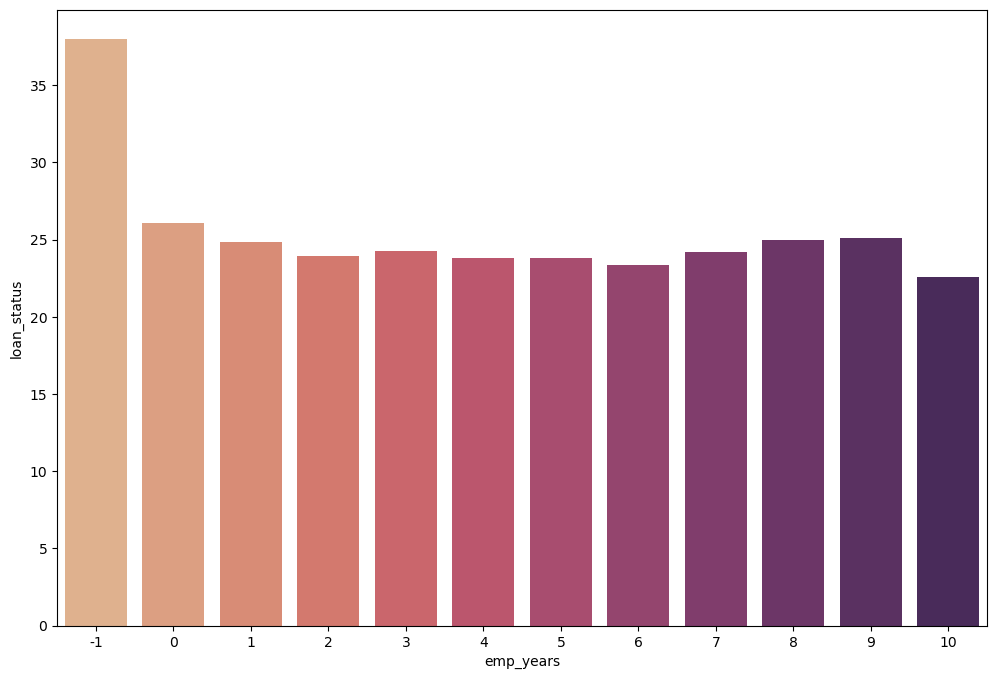

In [188]:
# Percentage loan_unrepaid per employment year 

emp_0 = df_ordered_emp_length[df_ordered_emp_length["loan_repaid"] == 0].groupby("emp_years").count()["loan_status"]
emp_1 = df_ordered_emp_length[df_ordered_emp_length["loan_repaid"] == 1].groupby("emp_years").count()["loan_status"]

emp_length = pd.DataFrame(emp_0/emp_1*100)

plt.figure(figsize=(12,8))
g = sns.barplot(data = emp_length, x="emp_years", y="loan_status", hue= "emp_years", palette = "flare")
g.legend_.remove()


In [189]:
# Drop emp_length, due to nearly similar results

df = df.drop("emp_length", axis=1)

In [190]:
# Analyzing title and purpose

df.filter(["title","purpose"]).value_counts()

title                                  purpose           
Debt consolidation                     debt_consolidation    152106
Credit card refinancing                credit_card            51354
Home improvement                       home_improvement       15182
Other                                  other                  12878
Debt Consolidation                     debt_consolidation     10837
                                                              ...  
Going green for good                   major_purchase             1
Going out high interest credit cards.  credit_card                1
Going to Make it                       credit_card                1
Going to be proud owner of home        house                      1
~Summer Fun~                           home_improvement           1
Name: count, Length: 54957, dtype: int64

In [191]:
# Drop title as it is correlated/duplicated to purpose

df = df.drop("title", axis=1)

In [192]:
# Analyzing Mort_acc

print(data_info.loc["mort_acc"]["Description"])

df["mort_acc"].value_counts()

Number of mortgage accounts.


mort_acc
0.0     139777
1.0      60416
2.0      49948
3.0      38049
4.0      27887
5.0      18194
6.0      11069
7.0       6052
8.0       3121
9.0       1656
10.0       865
11.0       479
12.0       264
13.0       146
14.0       107
15.0        61
16.0        37
17.0        22
18.0        18
19.0        15
20.0        13
24.0        10
22.0         7
21.0         4
25.0         4
27.0         3
32.0         2
31.0         2
23.0         2
26.0         2
28.0         1
30.0         1
34.0         1
Name: count, dtype: int64

In [193]:
# Identify correlations to mort_acc

df.corr(numeric_only=True)["mort_acc"].sort_values()

int_rate               -0.082583
dti                    -0.025439
revol_util              0.007514
pub_rec                 0.011552
pub_rec_bankruptcies    0.027239
loan_repaid             0.073111
open_acc                0.109205
emp_years               0.171096
installment             0.193694
revol_bal               0.194925
loan_amnt               0.222315
annual_inc              0.236320
total_acc               0.381072
mort_acc                1.000000
Name: mort_acc, dtype: float64

In [194]:
# Fill mort_acc based on total_acc_correaltion with mean

total_acc_avg = df.groupby("total_acc")['mort_acc'].mean()

print(total_acc_avg)

def fill_mort_acc(total_acc, mort_acc):
    if np.isnan(mort_acc):
        return total_acc_avg[total_acc]
    else:
        return mort_acc

df["mort_acc"] = df.apply(lambda x: fill_mort_acc(x["total_acc"], x["mort_acc"]), axis=1) 

total_acc
2.0      0.000000
3.0      0.052023
4.0      0.066743
5.0      0.103289
6.0      0.151293
           ...   
124.0    1.000000
129.0    1.000000
135.0    3.000000
150.0    2.000000
151.0    0.000000
Name: mort_acc, Length: 118, dtype: float64


In [195]:
df.isnull().sum()

loan_amnt                 0
term                      0
int_rate                  0
installment               0
grade                     0
sub_grade                 0
home_ownership            0
annual_inc                0
verification_status       0
issue_d                   0
loan_status               0
purpose                   0
dti                       0
earliest_cr_line          0
open_acc                  0
pub_rec                   0
revol_bal                 0
revol_util              276
total_acc                 0
initial_list_status       0
application_type          0
mort_acc                  0
pub_rec_bankruptcies    535
address                   0
loan_repaid               0
emp_years                 0
dtype: int64

In [196]:
# Info on last two columns with missing values

print(data_info.loc["revol_util"]["Description"])
print(data_info.loc["pub_rec_bankruptcies"]["Description"])

Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.
Number of public record bankruptcies


In [197]:
# Drop empty rows

df = df.dropna()

## 3. Clean Categorical Values

In [199]:
# Columns with categorical values

df.select_dtypes(['object']).columns

Index(['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status',
       'issue_d', 'loan_status', 'purpose', 'earliest_cr_line',
       'initial_list_status', 'application_type', 'address'],
      dtype='object')

In [200]:
# Analyze "term"
print(df["term"].value_counts())

term
36 months    301247
60 months     93972
Name: count, dtype: int64


In [201]:
df['term'] = df['term'].apply(lambda term: int(term[:3]))

In [202]:
# Drop "grade", as it is a sumamry to subgrade

df = df.drop("grade", axis=1)

In [203]:
# Get dummies for "sub_grade"

tmp = pd.get_dummies(data=df["sub_grade"], drop_first=True)
df = df.join(tmp)
df = df.drop("sub_grade", axis=1)

In [204]:
# Get dummies for "verification_status"

tmp = pd.get_dummies(data=df['verification_status'], drop_first=True)
df =  df.drop('verification_status', axis=1)
df = df.join(tmp)

In [205]:
# Get dummies for "application_type"

tmp = pd.get_dummies(data=df["application_type"], drop_first=True)
df =  df.drop("application_type", axis=1)
df = df.join(tmp)

In [206]:
# Get dummies for "list_status"

tmp = pd.get_dummies(data=df["initial_list_status"], drop_first=True)
df =  df.drop("initial_list_status", axis=1)
df = df.join(tmp)

In [207]:
# Get dummies for "purpose"

tmp = pd.get_dummies(data=df["purpose"], drop_first=True)
df =  df.drop("purpose", axis=1)
df = df.join(tmp)

In [208]:
# Analyse "Home_ownership"

df["home_ownership"].value_counts()

home_ownership
MORTGAGE    198022
RENT        159395
OWN          37660
OTHER          110
NONE            29
ANY              3
Name: count, dtype: int64

In [209]:
# Get dummies for "Home_ownership"

df["home_ownership"] = df["home_ownership"].replace(["NONE","ANY"],"OTHER")

tmp = pd.get_dummies(data=df["home_ownership"], drop_first=True)
df = df.drop("home_ownership", axis=1)
df = df.join(tmp)

In [210]:
# Extract zipcode from address

print(df["address"].value_counts)

df["zipcode"] = df["address"].apply(lambda x: x[-5:])

tmp = pd.get_dummies(data=df["zipcode"], drop_first=True)
df = df.drop(["zipcode","address"], axis=1)
df = df.join(tmp)


<bound method IndexOpsMixin.value_counts of 0              0174 Michelle Gateway\nMendozaberg, OK 22690
1           1076 Carney Fort Apt. 347\nLoganmouth, SD 05113
2           87025 Mark Dale Apt. 269\nNew Sabrina, WV 05113
3                     823 Reid Ford\nDelacruzside, MA 00813
4                      679 Luna Roads\nGreggshire, VA 11650
                                ...                        
396025       12951 Williams Crossing\nJohnnyville, DC 30723
396026    0114 Fowler Field Suite 028\nRachelborough, LA...
396027     953 Matthew Points Suite 414\nReedfort, NY 70466
396028    7843 Blake Freeway Apt. 229\nNew Michael, FL 2...
396029          787 Michelle Causeway\nBriannaton, AR 48052
Name: address, Length: 395219, dtype: object>


In [211]:
# Drop isse date, because we want to predict if there will be a loan or not

df = df.drop('issue_d', axis=1)

In [212]:
# Extract year from cr_line and drop cr_line

df["earliest_cr_year"] = df["earliest_cr_line"].apply(lambda x:int(x[-4:]))
df = df.drop("earliest_cr_line", axis=1)


In [256]:
# Drop loan_status and emp_years (we have loan_repaid already in 0,1)

df = df.drop("loan_status", axis=1)
df = df.drop("emp_years", axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 395219 entries, 0 to 396029
Data columns (total 79 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             395219 non-null  float64
 1   term                  395219 non-null  int64  
 2   int_rate              395219 non-null  float64
 3   installment           395219 non-null  float64
 4   annual_inc            395219 non-null  float64
 5   dti                   395219 non-null  float64
 6   open_acc              395219 non-null  float64
 7   pub_rec               395219 non-null  float64
 8   revol_bal             395219 non-null  float64
 9   revol_util            395219 non-null  float64
 10  total_acc             395219 non-null  float64
 11  mort_acc              395219 non-null  float64
 12  pub_rec_bankruptcies  395219 non-null  float64
 13  loan_repaid           395219 non-null  int32  
 14  A2                    395219 non-null  bool   
 15  A3   

## 4. Train/Test and Normalization

In [258]:
X = df.drop("loan_repaid", axis=1).values
y = df["loan_repaid"].values

In [260]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [262]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

X_train.shape

(316175, 78)

In [264]:
X_train

array([[0.10566518, 0.        , 0.66342034, ..., 0.        , 0.        ,
        0.70769231],
       [0.31508593, 1.        , 0.20724581, ..., 0.        , 0.        ,
        0.83076923],
       [0.10884787, 0.        , 0.4273471 , ..., 0.        , 0.        ,
        0.72307692],
       ...,
       [0.42266073, 1.        , 0.27931437, ..., 0.        , 0.        ,
        0.72307692],
       [0.08338638, 0.        , 0.24737047, ..., 0.        , 0.        ,
        0.78461538],
       [0.2616168 , 0.        , 0.02765875, ..., 0.        , 0.        ,
        0.70769231]])

## 5. Tensorflow Model

In [292]:
# Create Tensorflow model with 2 hidden layers and ReLu activation function
model = Sequential()

#input
model.add(Dense(78, activation="relu"))
model.add(Dropout(0.2))
# hidden 1
model.add(Dense(39, activation="relu"))
model.add(Dropout(0.2))
#hidden 2
model.add(Dense(19, activation="relu"))
model.add(Dropout(0.2))
#output
model.add(Dense(units=1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics = ["accuracy"])

In [296]:
# Fit model

model.fit(x=X_train, 
          y=y_train, 
          epochs=25,
          batch_size=256,
          validation_data=(X_test, y_test)
          )

Epoch 1/25
1236/1236 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8485 - loss: 0.3661 - val_accuracy: 0.8889 - val_loss: 0.2625
Epoch 2/25
1236/1236 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8886 - loss: 0.2656 - val_accuracy: 0.8889 - val_loss: 0.2613
Epoch 3/25
1236/1236 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8881 - loss: 0.2638 - val_accuracy: 0.8889 - val_loss: 0.2600
Epoch 4/25
1236/1236 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8881 - loss: 0.2623 - val_accuracy: 0.8889 - val_loss: 0.2599
Epoch 5/25
1236/1236 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8881 - loss: 0.2614 - val_accuracy: 0.8890 - val_loss: 0.2598
Epoch 6/25
1236/1236 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8884 - loss: 0.2605 - val_accuracy: 0.8888 - val_loss: 0.2595
Epoch 7/25
1236/1236 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8867 - loss: 0.2616 - val_accuracy: 0.8889 - val_loss: 0.2590
Epoch 8/25
1236/1236 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8884 - loss: 0.2600 - 

In [298]:
# Save model
model.save("modell_lendclub.keras")

## 6. Model Evaluation

In [314]:
# Gather results


model_results

,index,accuracy,loss,val_accuracy,val_loss
0,0,0.875667,0.302833,0.888897,0.262490
1,1,0.887904,0.265658,0.888910,0.261329
2,2,0.887907,0.263747,0.888897,0.259971
3,3,0.888122,0.262276,0.888948,0.259894
4,4,0.888135,0.261658,0.888961,0.259799
5,5,0.888027,0.261011,0.888783,0.259487
6,6,0.887920,0.260536,0.888885,0.258988
7,7,0.888056,0.260311,0.888834,0.258956
8,8,0.888116,0.259914,0.888885,0.258990
9,9,0.888217,0.259819,0.888872,0.258803


Text(0.5, 1.0, 'Loss')

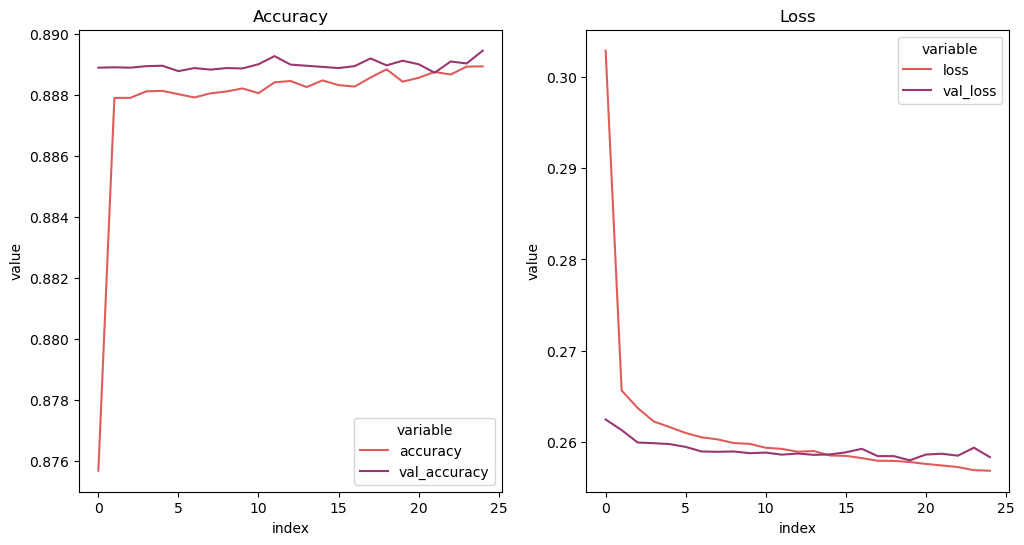

In [338]:
# Evaluation values

model_results = pd.DataFrame(model.history.history)
model_results.reset_index(inplace=True)

# Data prep
model_results_accuracy = pd.melt(model_results, id_vars="index", value_vars=["accuracy","val_accuracy"])
model_results_loss = pd.melt(model_results, id_vars="index", value_vars=["loss","val_loss"])

# Plot data
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
axes[0].set_title("Model Evaluation")
sns.lineplot(data = model_results_accuracy, x="index", y="value", hue="variable", palette="flare", ax=axes[0])
axes[0].set_title("Accuracy")
sns.lineplot(data = model_results_loss, x="index", y="value", hue="variable", palette="flare", ax=axes[1])
axes[1].set_title("Loss")

# Summary

In this exercise a complex and large dataset was 
1. analyzed for correlations and distributions
2. prepared by cleaning, filling and numerisiing categorical values
3. trained with Keras and Tensorflow Deep Learning network
4. and finally the model evaluated.
